<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Capstone Project - Identifying Offensive Tweets

# Information

This is my capstone project for the General Assembly Data Science Immersive course.

This is the second notebook of this project.

In this notebook, the steps conducted are:

    1. Exploratory Data Analysis

**CONTENT WARNING: This project includes content that are sensitive and may be offensive to some viewers. These topics include mentions (many negative) and slurs of race, religion, and gender.**

**NOTE: All text information that are used in this project are directly taken from the websites and do not reflect what I believe in. All tags (whether a tweet is racist/sexist, or not) are taken as is from the source.**

For the purpose of this project, the offensive tweets of interest are ones that are racist and sexist. 

Racist tweets are defined as those that have antagonistic sentiments toward certain religious figures or individuals from a religious group, and/or individuals or groups from a certain race. Given the dataset 'classified_tweets' not separating the racist and sacrilegious/blasphemous (anti-religious) tweets, the 'racist' tag will be applied for both categories.

Sexist tweets are defined as those that have misogynistic, homophobic, and/or transphobic sentiments.

# Background

Twitter is a micro-blogging social media platform with 217.5 million daily active users globally. With 500 million new tweets (posts) daily, the topics of these tweets varies widely – k-pop, politics, financial news… you name it! Individuals use it for news, entertainment, and discussions, while corporations use them to as a marketing tool to reach out to a wide audience. Given the freedom Twitter accords to its user, Twitter can provide a conducive environment for productive discourse, but this freedom can also be abused, manifesting in the forms of racism and sexism.

# Problem Statement

With Twitter’s significant income stream coming from advertisers, it is imperative that Twitter keeps a substantial user base. On the other hand, Twitter should maintain a safe space for users and provide some level of checks for the tweets the users put out into the public space, and the first step would be to identify tweets that espouse racist or sexist ideologies, and then Twitter can direct the users to appropriate sources of information where users can learn more about the community that they offend or their subconscious biases so they will be more aware of their racist/sexist tendencies. Thus, to balance, Twitter has to be accurate in filtering inappropriate tweets from innocuous ones, and the kind of inappropriateness of flagged tweets (tag - racist or sexist).

F1-scores will be the primary metric as it looks at both precision and recall, each looking at false positives (FPs) and false negatives (FNs) respectively, and is a popular metric for imbalanced data as is the case with the dataset used.

For the purpose of explanation, racist tweets are used as the ‘positive’ case.

In this context, FPs are the cases where the model erroneously flags out tweets as racist when the tweet is actually innocuous/sexist. FNs are cases where the model erroneously flags out tweets as innocuous/sexist but the tweets are actually racist.

There is a need to balance the identification of an offensive tweet when it is indeed offensive and the need to maintain a high level of user experience (something that would be jeopardized when the model erroneously flags innocuous tweets as offensive).

Thus, higher F1-score is the preferred metric to assess model performance.

# Importing Libraries

In [1]:
# Standard libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# For NLP data cleaning and preprocessing
import re, string, nltk, itertools
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import demoji

# For general preprocessing
from sklearn.model_selection import train_test_split

In [2]:
# Changing display settings
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_row', 100)

# Importing Datasets

In [3]:
data = pd.read_csv('../data/data.csv')

In [4]:
data.columns

Index(['tag', 'set', 'text', 'word_count'], dtype='object')

In [5]:
data.head()

,tag,set,text,word_count
0,0,train,word katandandre food crapilicious mkr,5
1,0,train,aussietv white mkr theblock imacelebrityau today sunrise studio10 neighbour wonderlandten etc,11
2,0,train,classy whore red velvet cupcake,5
3,0,train,meh p thanks head concerned another angry dude twitter,9
4,0,train,isi account pretend kurdish account like islam lie,8


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51811 entries, 0 to 51810
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tag         51811 non-null  int64 
 1   set         51811 non-null  object
 2   text        51426 non-null  object
 3   word_count  51811 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1.6+ MB


In [7]:
# Splitting for analysis
train = data.loc[data['set'] == 'train']
test = data.loc[data['set'] == 'test']

In [8]:
print(train.shape)
print(test.shape)

(31877, 4)
(19934, 4)


In [9]:
# Removing tweets with low word (cleaned) count
train = train.loc[train['word_count'] >= 4]

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29747 entries, 0 to 31876
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tag         29747 non-null  int64 
 1   set         29747 non-null  object
 2   text        29747 non-null  object
 3   word_count  29747 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1.1+ MB


There are 29747 remaining tweets in the train dataset after removing for cleaned tweets containing 3 or fewer words.

# Reducing Train Dataset Size

This is done due to computing resource limitations. This reduction is executed by randomly reducing 50% of tweets from each category.

This reduction would maintain the proportion of each tag in the train dataset.

In [11]:
# Looking at original weights of each tag
train['tag'].value_counts(normalize = True)

1    0.529902
2    0.253673
0    0.216425
Name: tag, dtype: float64

In [12]:
X = train[['set','text','word_count']]
y = train['tag']

In [13]:
# Conducting 'train/test split' so that dataset will be downsized whilst keeping proportion of tags
# Will be using the 'test' set as the new train dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, stratify = y)

In [14]:
print(y_test.shape)
print(X_test.shape)

(14874,)
(14874, 3)


In [15]:
y_test.value_counts(normalize = True)

1    0.529918
2    0.253664
0    0.216418
Name: tag, dtype: float64

In [16]:
# Reconstruct reduced dataset
train = pd.concat([y_test, X_test], axis = 1)

In [17]:
train.head()

,tag,set,text,word_count
13101,2,train,way insult direct man unflattering hat worn predominantly men meant ins…,11
20352,1,train,ordinary muslim idiot person like know make sure qur’an muslim nothing claim jihad come back tal...,21
16034,1,train,give buildup sweeden government idiotu behave like allrounder see reach god know many fake news ...,29
5038,0,train,sure pot cooked hot mkr killerblondes abarmezh86,7
23824,1,train,christian part palestinian kill driven palestinian muslim,7


# Tweet Length Analysis

The following plots are based on the train (seen) dataset.

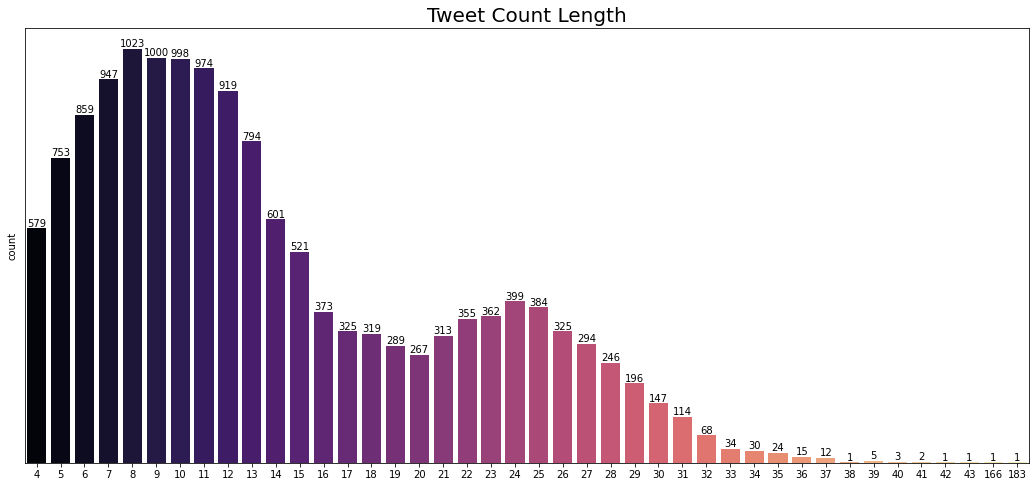

In [18]:
# Plotting for tweets word count
plt.figure(figsize = (18,8))
ax = sns.countplot(x = 'word_count', data = train, palette = 'magma')
plt.title('Tweet Count Length', fontsize = 20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.savefig('../data/tweet_count_length.jpg', bbox_inches='tight')
plt.show();

# Preprocessing for Word n-gram EDA

This preprocessing step is for plotting purposes. The preproccessing method transforms the text columns into BagofWords using CountVectoizer as it is just a simple count of each unique word that is plotted.

In [19]:
# Instantiating CountVectorizers

# unigram
cv1 = CountVectorizer()

# bigram
cv2 = CountVectorizer(ngram_range = (2, 2))

# trigram
cv3 = CountVectorizer(ngram_range = (3, 3))

### Unigram

In [20]:
# Preprocessing for unigram
cv1.fit(train['text'])

train_cv1_racism = cv1.transform(train['text'][train['tag'] == 1])
train_cv1_sexism = cv1.transform(train['text'][train['tag'] == 2])
train_cv1_racism_df = pd.DataFrame(train_cv1_racism.todense(), columns = cv1.get_feature_names_out())
train_cv1_sexism_df = pd.DataFrame(train_cv1_sexism.todense(), columns = cv1.get_feature_names_out())

### Bigram

In [21]:
# Preprocessing for bigram
cv2.fit(train['text'])

train_cv2_racism = cv2.transform(train['text'][train['tag'] == 1])
train_cv2_sexism = cv2.transform(train['text'][train['tag'] == 2])
train_cv2_racism_df = pd.DataFrame(train_cv2_racism.todense(), columns = cv2.get_feature_names_out())
train_cv2_sexism_df = pd.DataFrame(train_cv2_sexism.todense(), columns = cv2.get_feature_names_out())

### Trigram

In [22]:
# Preprocessing for trigram
cv3.fit(train['text'])

train_cv3_racism = cv3.transform(train['text'][train['tag'] == 1])
train_cv3_sexism = cv3.transform(train['text'][train['tag'] == 2])
train_cv3_racism_df = pd.DataFrame(train_cv3_racism.todense(), columns = cv3.get_feature_names_out())
train_cv3_sexism_df = pd.DataFrame(train_cv3_sexism.todense(), columns = cv3.get_feature_names_out())

# Word n-gram Analysis

### Unigram

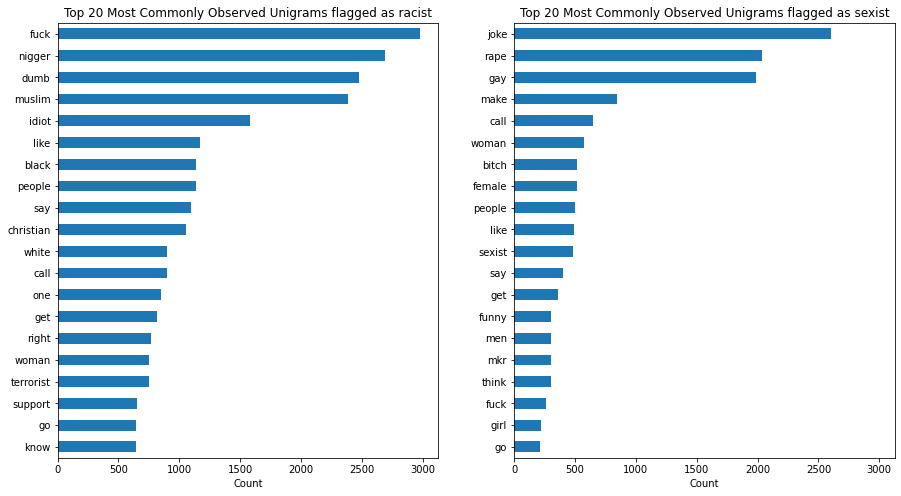

In [23]:
# Plotting the top 20 commonly observed unigram
fig, ax = plt.subplots(nrows = 1, ncols = 2, sharex = True, figsize = (15,8))
ax = ax.ravel()

plt.subplots_adjust(hspace = 0.1)

# Setting up plot for sexism
train_cv1_racism_df.sum().sort_values(ascending = True).tail(20).plot(kind = 'barh',ax = ax[0])
ax[0].set_title('Top 20 Most Commonly Observed Unigrams flagged as racist')
ax[0].set_xlabel('Count')

# Setting up plot for racism
train_cv1_sexism_df.sum().sort_values(ascending = True).tail(20).plot(kind = 'barh',ax = ax[1])
ax[1].set_title('Top 20 Most Commonly Observed Unigrams flagged as sexist')
ax[1].set_xlabel('Count')

plt.savefig('../data/word_unigram.jpg', bbox_inches = 'tight');

For the unigrams from tweets flagged as racist, there are:
- expletive: fuck
- mentions of race: white, black (with the n-word slur)
- insult: dumb
- mentions of Abrahamic faith: muslim, christian
- mentions of extremism: terrorist

For the unigrams from tweets flagged as sexist, there are:
- mentions of sexual assault: rape
- mentions of gender: woman, female, men, girl
- insult: dumb
- mentions of sexuality: gay
- mentions of mkr - stands for My Kitchen Rules, an Australian competitive cooking game show that has shown scenes where contestants hurled sexist remarks to female contestants, and where discussions online has garnered significant misogynistic sentiments
- expletive: fuck

### Bigram

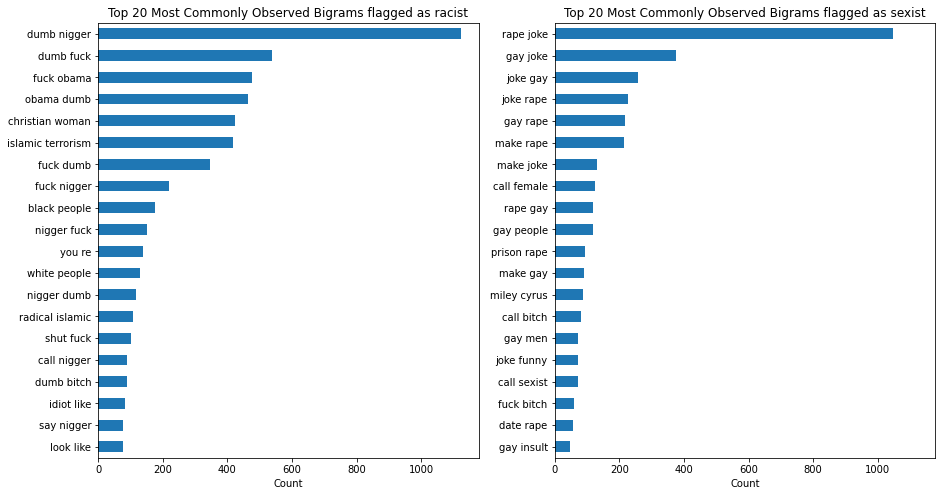

In [24]:
# Plotting the top 20 commonly observed bigram
fig, ax = plt.subplots(nrows = 1, ncols = 2, sharex = True, figsize = (15,8))
ax = ax.ravel()

plt.subplots_adjust(hspace = 0.1)

# Setting up plot for sexism
train_cv2_racism_df.sum().sort_values(ascending = True).tail(20).plot(kind = 'barh',ax = ax[0])
ax[0].set_title('Top 20 Most Commonly Observed Bigrams flagged as racist')
ax[0].set_xlabel('Count')

# Setting up plot for racism
train_cv2_sexism_df.sum().sort_values(ascending = True).tail(20).plot(kind = 'barh',ax = ax[1])
ax[1].set_title('Top 20 Most Commonly Observed Bigrams flagged as sexist')
ax[1].set_xlabel('Count')

plt.savefig('../data/word_bigram.jpg', bbox_inches = 'tight');

For the bigrams from tweets flagged as racist, there are:
- directed insults: dumb and fuck found before and after the mention of the n-word -  this gives us more information on the recipient of most racist tweets
- attack on polical figures: fuck obama - Barack Obama is the first black President of the United States, another attack on the black community
- mentions of other demography: christian woman, white people - this gives us more information about the other profiles of people involved in racist tweets
- links to religious extremism: islamic terrorism, radical islamic - the extremism mentioned in tweets are those relating to islam

For bigrams from tweets flagged as sexist, there are:
- downplaying/dismissal of severe/sensitive topics: permutations and combinations of the words 'rape', 'gay', joke'
- mention of celebrity: miley cyrus - an American singer-songwriter who was in the spotlight for making a date-rape joke at a club gig

### Trigram

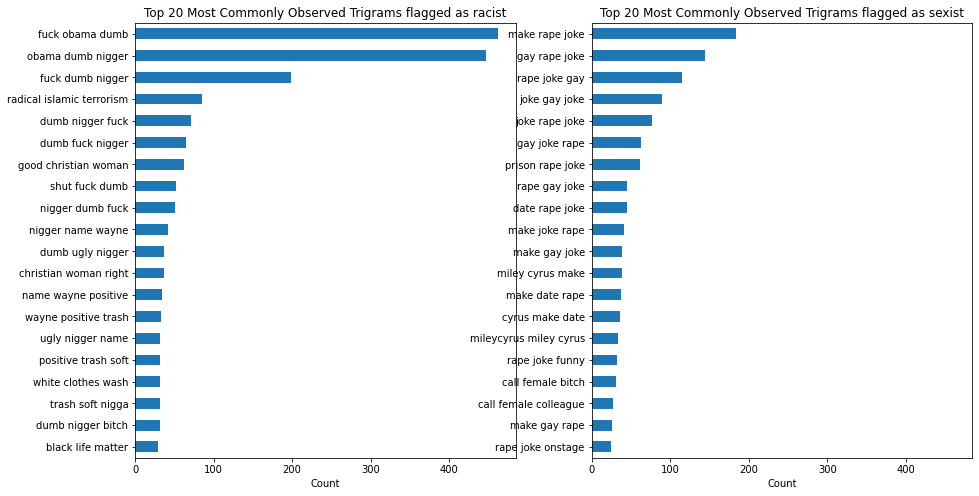

In [25]:
# Plotting the top 20 commonly observed trigram
fig, ax = plt.subplots(nrows = 1, ncols = 2, sharex = True, figsize = (15,8))
ax = ax.ravel()

plt.subplots_adjust(hspace = 0.1)

# Setting up plot for sexism
train_cv3_racism_df.sum().sort_values(ascending = True).tail(20).plot(kind = 'barh',ax = ax[0])
ax[0].set_title('Top 20 Most Commonly Observed Trigrams flagged as racist')
ax[0].set_xlabel('Count')

# Setting up plot for racism
train_cv3_sexism_df.sum().sort_values(ascending = True).tail(20).plot(kind = 'barh',ax = ax[1])
ax[1].set_title('Top 20 Most Commonly Observed Trigrams flagged as sexist')
ax[1].set_xlabel('Count')

plt.savefig('../data/word_trigram.jpg', bbox_inches = 'tight');

For the trigrams from tweets flagged as racist, there is not much additional information we can gather that we did not from bigrams, though an additional piece of information uncovered here is the mention of black life matter, which is a decentralized political and social movement that strives to highlight the discrimination, racism, and inequality that the black community face.

For the trigrams from tweets flagged as sexist, there is also not much additional information we can gather that are not already seen from bigrams.

# Exporting Dataset

In [26]:
# Combining reduced train dataset with test set
data = pd.concat([train, test], axis = 0)
data.shape

(34808, 4)

In [27]:
# Dropping word_count column
data = data.drop(columns = 'word_count')

# Exporting
data.to_csv('../data/data_v1.csv', index = False)